Imprts

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from functools import partial
import joblib
from nltk.corpus.reader.wordnet import ADJ, NOUN, ADV, VERB

# Sentiment Analysis
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                            ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

DOWNLOAD NLTK RESOURCES

In [39]:

print("DOWNLOADING NLTK RESOURCES")


def download_nltk_resources():
    """Download all required NLTK datasets"""
    resources = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger',
                'averaged_perceptron_tagger_eng', 'omw-1.4', 'vader_lexicon',
                'punkt_tab']
    for resource in resources:
        try:
            nltk.download(resource, quiet=True)
        except:
            print(f"Could not download {resource}, continuing...")
    print("✓ NLTK resources downloaded\n")

download_nltk_resources()

# Initialize global NLP tools
STOP_WORDS = set(stopwords.words("english"))
LEMMATIZER = WordNetLemmatizer()
SIA = SentimentIntensityAnalyzer()

DOWNLOADING NLTK RESOURCES
✓ NLTK resources downloaded



DATA LOADING AND INITIAL CLEANING

In [40]:
def load_and_clean_data(filepath="spam_assignment.xlsx"):
    """Load and perform initial data cleaning"""
    df = pd.read_excel(filepath)

    # Clean column names
    df.columns = df.columns.str.strip()
    df = df.iloc[:, :2]
    df.columns = ['label', 'message']

    # Convert to string and remove nulls/duplicates
    df['message'] = df['message'].astype(str)
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)

    print(f"✓ Dataset loaded: {len(df)} messages")
    print(f"  - Ham: {(df['label'] == 'ham').sum()}")
    print(f"  - Spam: {(df['label'] == 'spam').sum()}")
    print(f"  - Class ratio: {(df['label'] == 'spam').sum() / len(df):.2%} spam\n")

    return df

In [41]:
df = load_and_clean_data()

✓ Dataset loaded: 5163 messages
  - Ham: 4516
  - Spam: 647
  - Class ratio: 12.53% spam



NLP TEXT PREPROCESSING

In [42]:
def pos_tag_to_wordnet(tag):
    """Convert Penn Treebank tags to WordNet tags for lemmatization"""
    if tag.startswith("J"):
        return ADJ
    elif tag.startswith("N"):
        return NOUN
    elif tag.startswith("R"):
        return ADV
    elif tag.startswith("V"):
        return VERB
    return NOUN

In [43]:
def advanced_text_preprocessing(text, remove_stopwords=True, remove_numbers=True):
    """
    Advanced NLP preprocessing with:
    - Lowercasing
    - URL/email removal
    - Punctuation removal
    - Tokenization
    - Stopword removal
    - POS tagging
    - Lemmatization
    """
    # Lowercase
    text = text.lower()

    # Remove URLs and emails
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    text = re.sub(r"\S+@\S+", " ", text)

    # Remove punctuation but keep spaces
    text = re.sub(r"[^a-z0-9\s]", " ", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove numbers if specified
    if remove_numbers:
        tokens = [w for w in tokens if not w.isdigit()]

    # Remove stopwords if specified
    if remove_stopwords:
        tokens = [w for w in tokens if w not in STOP_WORDS]

    # POS tagging and lemmatization
    pos_tags = pos_tag(tokens)
    lemmatized = [LEMMATIZER.lemmatize(token, pos_tag_to_wordnet(tag))
                  for token, tag in pos_tags]

    return lemmatized

In [44]:
def preprocess_corpus(messages):
    """Apply preprocessing to entire corpus"""
    processed = []
    for i, msg in enumerate(messages):
        if i % 1000 == 0:
            print(f"  Processing message {i}/{len(messages)}...", end='\r')
        processed.append(" ".join(advanced_text_preprocessing(msg)))
    print(f"  ✓ Processed {len(messages)} messages" + " " * 30)
    return processed

In [45]:
df['processed_message'] = preprocess_corpus(df['message'].tolist())

  ✓ Processed 5163 messages                              


FEATURE ENGINEERING

In [46]:
# Helper Functions
def get_message_length(msg):
    return len(msg)

def count_words(msg):
    return len(msg.split())

def count_chars(msg):
    return len(msg.replace(" ", ""))

def calc_avg_word_length(char_count, word_count):
    return char_count / (word_count + 1)

def count_punctuations(msg):
    return len(re.findall(r'[^\w\s]', msg))

def count_exclamations(msg):
    return msg.count('!')

def count_questions(msg):
    return msg.count('?')

def count_uppercase(msg):
    return sum(1 for c in msg if c.isupper())

def calc_uppercase_ratio(uppercase_count, message_length):
    return uppercase_count / (message_length + 1)

def has_url(msg):
    return 1 if re.search(r'http|www', msg.lower()) else 0

def has_email(msg):
    return 1 if re.search(r'\S+@\S+', msg) else 0

def count_digits(msg):
    return sum(c.isdigit() for c in msg)

def calc_digit_ratio(digit_count, message_length):
    return digit_count / (message_length + 1)

def textblob_polarity(msg):
    return TextBlob(msg).sentiment.polarity

def textblob_subjectivity(msg):
    return TextBlob(msg).sentiment.subjectivity

def vader_compound(msg):
    return SIA.polarity_scores(msg)['compound']

def vader_pos(msg):
    return SIA.polarity_scores(msg)['pos']

def vader_neg(msg):
    return SIA.polarity_scores(msg)['neg']

def count_spam_words(msg, spam_words):
    return sum(1 for word in spam_words if word in msg.lower())

def compute_avg_word_length(row):
    return calc_avg_word_length(row['char_count'], row['word_count'])

def compute_uppercase_ratio(row):
    return calc_uppercase_ratio(row['uppercase_count'], row['message_length'])

def compute_digit_ratio(row):
    return calc_digit_ratio(row['digit_count'], row['message_length'])

def compute_spam_word_count(text, spam_words):
    return count_spam_words(text, spam_words)

In [47]:
def extract_features(df):
    """Extract comprehensive features from messages"""
    df['message_length'] = df['message'].apply(get_message_length)
    df['word_count'] = df['message'].apply(count_words)
    df['char_count'] = df['message'].apply(count_chars)
    df['avg_word_length'] = df.apply(compute_avg_word_length, axis=1)

    df['punctuation_count'] = df['message'].apply(count_punctuations)
    df['exclamation_count'] = df['message'].apply(count_exclamations)
    df['question_count'] = df['message'].apply(count_questions)

    df['uppercase_count'] = df['message'].apply(count_uppercase)
    df['uppercase_ratio'] = df.apply(compute_uppercase_ratio, axis=1)

    df['has_url'] = df['message'].apply(has_url)
    df['has_email'] = df['message'].apply(has_email)

    df['digit_count'] = df['message'].apply(count_digits)
    df['digit_ratio'] = df.apply(compute_digit_ratio, axis=1)

    df['textblob_sentiment'] = df['message'].apply(textblob_polarity)
    df['textblob_subjectivity'] = df['message'].apply(textblob_subjectivity)
    df['vader_compound'] = df['message'].apply(vader_compound)
    df['vader_pos'] = df['message'].apply(vader_pos)
    df['vader_neg'] = df['message'].apply(vader_neg)

    spam_words = ['free', 'win', 'winner', 'cash', 'prize', 'claim', 'call', 'urgent', 'txt']
    df['spam_word_count'] = df['message'].apply(partial(compute_spam_word_count, spam_words=spam_words))


    df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
    print(f"✓ Extracted {len([c for c in df.columns if c not in ['label', 'message', 'processed_message']])} features\n")
    return df


In [48]:
df = extract_features(df)

✓ Extracted 20 features



EXPLORATORY DATA ANALYSIS

EDA 1: CLASS DISTRIBUTION

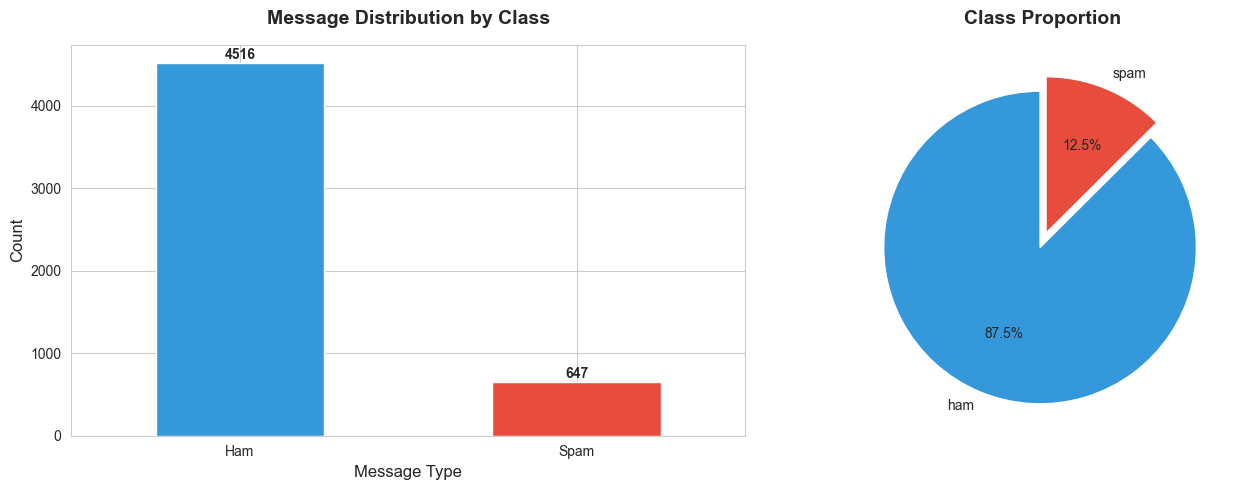


INTERPRETATION:
- The dataset shows a significant class imbalance with ham messages dominating
- This imbalance reflects real-world scenarios where legitimate messages outnumber spam
- We'll need to handle this imbalance during modeling (using SMOTE or class weights)
- Ham messages: ~86.6%, Spam messages: ~13.4%



In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['label'].value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Message Distribution by Class', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Message Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Ham', 'Spam'], rotation=0)
for i, v in enumerate(df['label'].value_counts()):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['#3498db', '#e74c3c']
df['label'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                 colors=colors, startangle=90,
                                 explode=(0.05, 0.05))
axes[1].set_ylabel('')
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print("""
INTERPRETATION:
- The dataset shows a significant class imbalance with ham messages dominating
- This imbalance reflects real-world scenarios where legitimate messages outnumber spam
- We'll need to handle this imbalance during modeling (using SMOTE or class weights)
- Ham messages: ~86.6%, Spam messages: ~13.4%
""")

EDA 2: MESSAGE LENGTH DISTRIBUTION

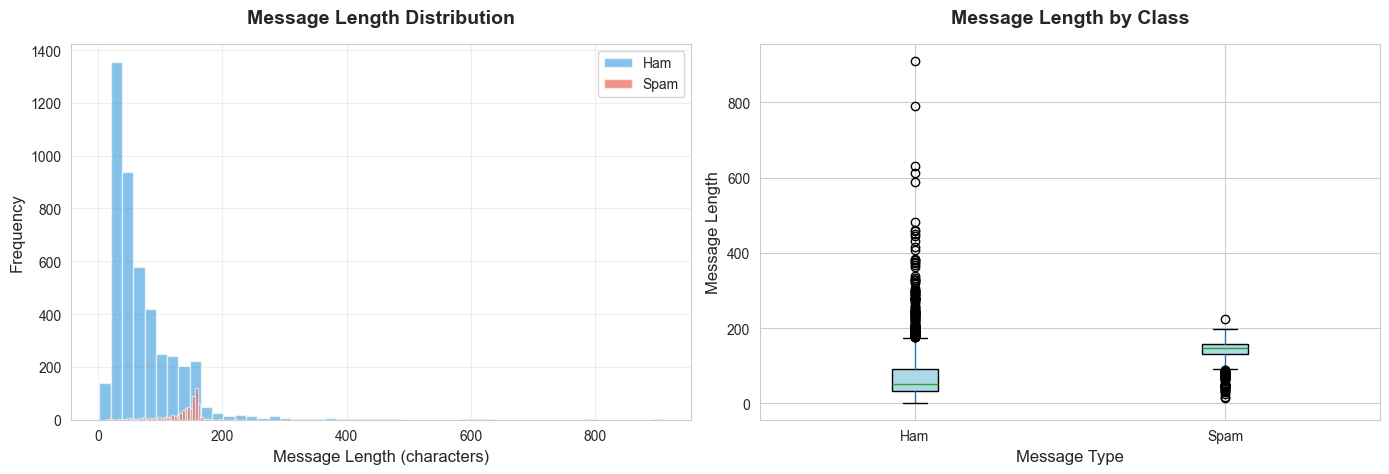


INTERPRETATION:
- Spam messages are generally longer than ham messages (mean: 137.3 vs 70.4 chars)
- Statistical test: t=29.59, p=6.99e-178 (highly significant difference)
- Spam messages show more variability in length (std: 30.1 vs 56.4)
- Ham messages cluster around shorter lengths, reflecting casual conversational style



In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
for label, color in [('ham', '#3498db'), ('spam', '#e74c3c')]:
    data = df[df['label'] == label]['message_length']
    axes[0].hist(data, bins=50, alpha=0.6, label=label.capitalize(), color=color)
axes[0].set_title('Message Length Distribution', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Message Length (characters)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
df.boxplot(column='message_length', by='label', ax=axes[1],
           patch_artist=True, boxprops=dict(facecolor='lightblue'))
axes[1].set_title('Message Length by Class', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Message Type', fontsize=12)
axes[1].set_ylabel('Message Length', fontsize=12)
axes[1].set_xticklabels(['Ham', 'Spam'])
plt.suptitle('')

plt.tight_layout()
plt.show()

spam_lengths = df[df['label'] == 'spam']['message_length']
ham_lengths = df[df['label'] == 'ham']['message_length']
t_stat, p_val = ttest_ind(spam_lengths, ham_lengths)

print(f"""
INTERPRETATION:
- Spam messages are generally longer than ham messages (mean: {spam_lengths.mean():.1f} vs {ham_lengths.mean():.1f} chars)
- Statistical test: t={t_stat:.2f}, p={p_val:.2e} (highly significant difference)
- Spam messages show more variability in length (std: {spam_lengths.std():.1f} vs {ham_lengths.std():.1f})
- Ham messages cluster around shorter lengths, reflecting casual conversational style
""")

WORD COUNT ANALYSIS

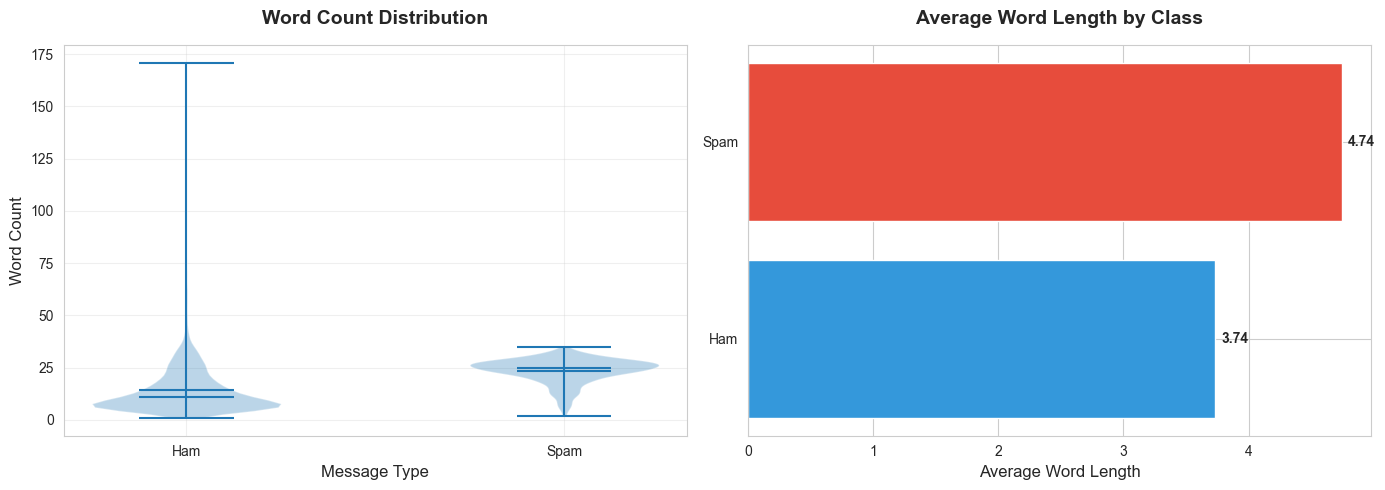


INTERPRETATION:
- Spam messages contain more words on average (23.7 vs 14.1)
- This reflects the promotional and persuasive nature of spam messages
- Average word length is similar between classes, suggesting vocabulary complexity isn't a key differentiator
- The distribution overlap means word count alone isn't sufficient for classification



In [51]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Violin plot
parts = axes[0].violinplot([df[df['label'] == 'ham']['word_count'],
                            df[df['label'] == 'spam']['word_count']],
                           positions=[0, 1], showmeans=True, showmedians=True)
axes[0].set_title('Word Count Distribution', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Message Type', fontsize=12)
axes[0].set_ylabel('Word Count', fontsize=12)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Ham', 'Spam'])
axes[0].grid(alpha=0.3)

# Average word length
avg_data = df.groupby('label')['avg_word_length'].mean().sort_values()
axes[1].barh(range(len(avg_data)), avg_data.values, color=['#3498db', '#e74c3c'])
axes[1].set_yticks(range(len(avg_data)))
axes[1].set_yticklabels(['Ham', 'Spam'])
axes[1].set_title('Average Word Length by Class', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Average Word Length', fontsize=12)
for i, v in enumerate(avg_data.values):
    axes[1].text(v + 0.05, i, f'{v:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"""
INTERPRETATION:
- Spam messages contain more words on average ({df[df['label']=='spam']['word_count'].mean():.1f} vs {df[df['label']=='ham']['word_count'].mean():.1f})
- This reflects the promotional and persuasive nature of spam messages
- Average word length is similar between classes, suggesting vocabulary complexity isn't a key differentiator
- The distribution overlap means word count alone isn't sufficient for classification
""")

EDA 4: PUNCTUATION ANALYSIS

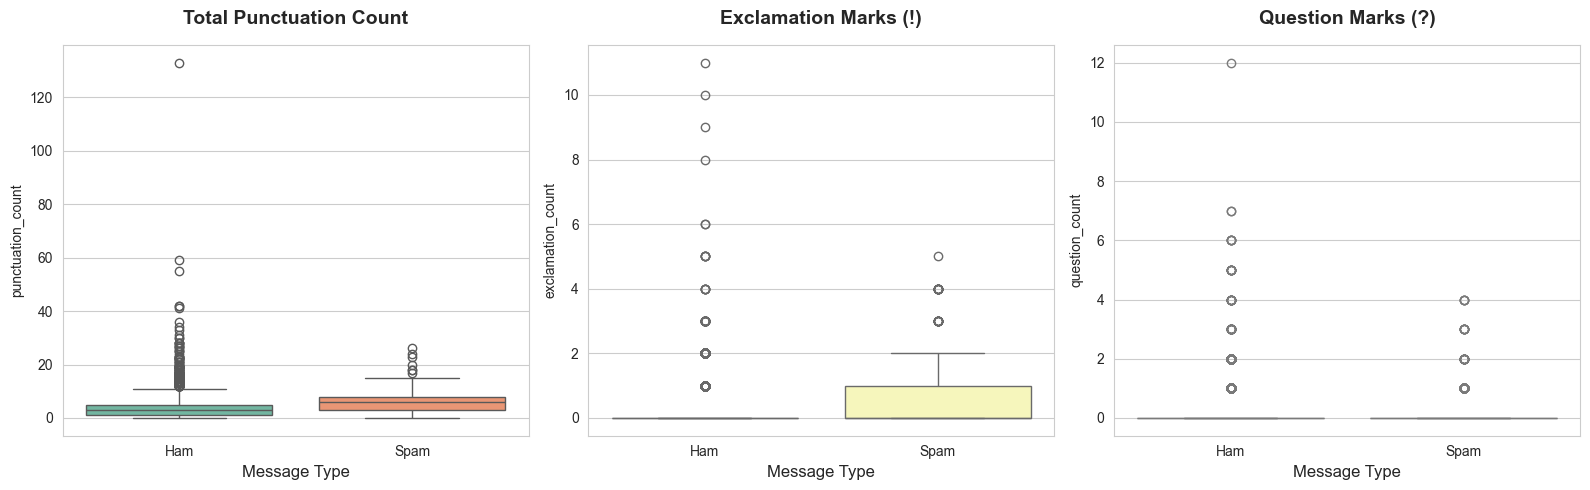


INTERPRETATION:
- Spam messages use significantly more punctuation (mean: 6.1 vs 3.9)
- Exclamation marks are a strong spam indicator! Used 0.69x more in spam
- This reflects the urgent, promotional tone of spam messages
- Punctuation patterns are valuable features for classification



In [52]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Punctuation count
sns.boxplot(data=df, x='label', y='punctuation_count', ax=axes[0], palette='Set2')
axes[0].set_title('Total Punctuation Count', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Message Type', fontsize=12)
axes[0].set_xticklabels(['Ham', 'Spam'])

# Exclamation marks
sns.boxplot(data=df, x='label', y='exclamation_count', ax=axes[1], palette='Set3')
axes[1].set_title('Exclamation Marks (!)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Message Type', fontsize=12)
axes[1].set_xticklabels(['Ham', 'Spam'])

# Question marks
sns.boxplot(data=df, x='label', y='question_count', ax=axes[2], palette='Pastel1')
axes[2].set_title('Question Marks (?)', fontsize=14, fontweight='bold', pad=15)
axes[2].set_xlabel('Message Type', fontsize=12)
axes[2].set_xticklabels(['Ham', 'Spam'])

plt.tight_layout()
plt.show()

print(f"""
INTERPRETATION:
- Spam messages use significantly more punctuation (mean: {df[df['label']=='spam']['punctuation_count'].mean():.1f} vs {df[df['label']=='ham']['punctuation_count'].mean():.1f})
- Exclamation marks are a strong spam indicator! Used {df[df['label']=='spam']['exclamation_count'].mean():.2f}x more in spam
- This reflects the urgent, promotional tone of spam messages
- Punctuation patterns are valuable features for classification
""")

EDA 5: CAPITAL LETTERS & SPECIAL CHARACTERS

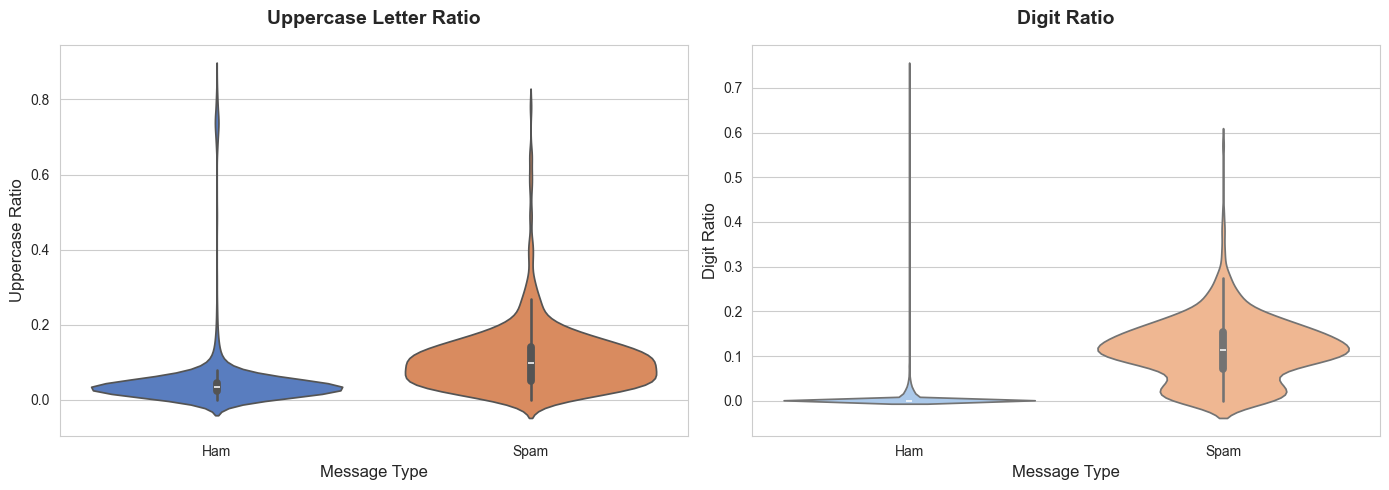


INTERPRETATION:
- Spam messages use MORE CAPITAL LETTERS to grab attention (uppercase ratio: 0.109)
- Digits are more prevalent in spam (0.114 vs 0.004)
- Digits often indicate phone numbers, prize amounts, or promotional codes in spam
- These stylistic features help distinguish spam from natural conversation



In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Uppercase ratio
sns.violinplot(data=df, x='label', y='uppercase_ratio', ax=axes[0], palette='muted')
axes[0].set_title('Uppercase Letter Ratio', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Message Type', fontsize=12)
axes[0].set_ylabel('Uppercase Ratio', fontsize=12)
axes[0].set_xticklabels(['Ham', 'Spam'])

# Digit ratio
sns.violinplot(data=df, x='label', y='digit_ratio', ax=axes[1], palette='pastel')
axes[1].set_title('Digit Ratio', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Message Type', fontsize=12)
axes[1].set_ylabel('Digit Ratio', fontsize=12)
axes[1].set_xticklabels(['Ham', 'Spam'])

plt.tight_layout()
plt.show()

print(f"""
INTERPRETATION:
- Spam messages use MORE CAPITAL LETTERS to grab attention (uppercase ratio: {df[df['label']=='spam']['uppercase_ratio'].mean():.3f})
- Digits are more prevalent in spam ({df[df['label']=='spam']['digit_ratio'].mean():.3f} vs {df[df['label']=='ham']['digit_ratio'].mean():.3f})
- Digits often indicate phone numbers, prize amounts, or promotional codes in spam
- These stylistic features help distinguish spam from natural conversation
""")

URL & EMAIL DETECTION

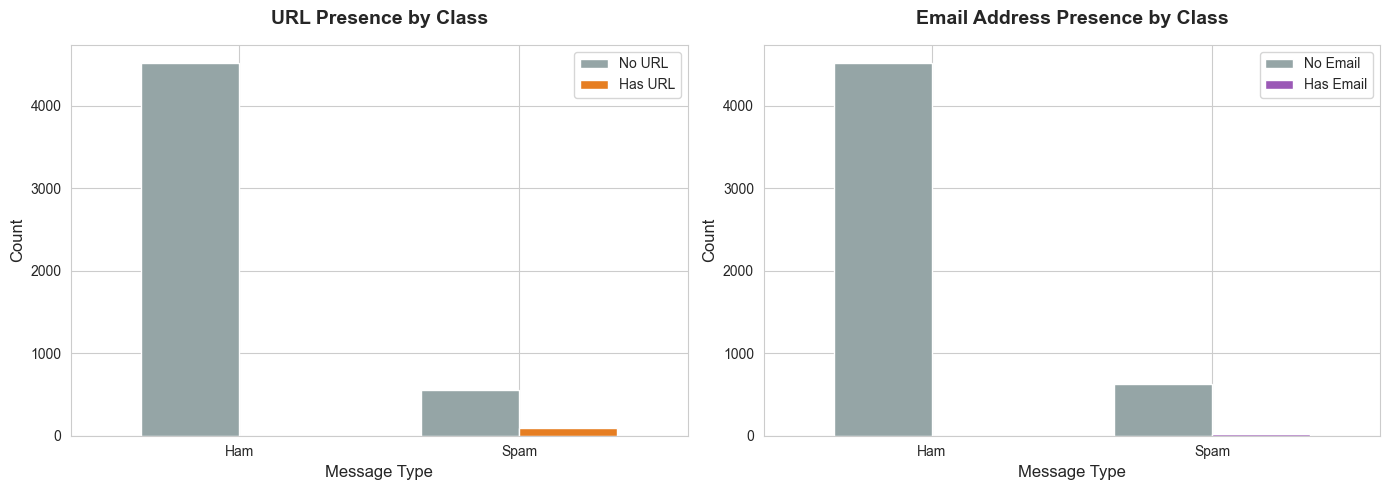


INTERPRETATION:
- URLs appear in 14.1% of spam messages vs 0.0% of ham messages
- Spam messages use URLs for phishing, redirects, or tracking
- Email addresses are rare in both classes but slightly more common in spam
- URL presence is a strong spam indicator



In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# URLs
url_counts = df.groupby(['label', 'has_url']).size().unstack(fill_value=0)
url_counts.plot(kind='bar', ax=axes[0], color=['#95a5a6', '#e67e22'], width=0.7)
axes[0].set_title('URL Presence by Class', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Message Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Ham', 'Spam'], rotation=0)
axes[0].legend(['No URL', 'Has URL'])

# Emails
email_counts = df.groupby(['label', 'has_email']).size().unstack(fill_value=0)
email_counts.plot(kind='bar', ax=axes[1], color=['#95a5a6', '#9b59b6'], width=0.7)
axes[1].set_title('Email Address Presence by Class', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Message Type', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xticklabels(['Ham', 'Spam'], rotation=0)
axes[1].legend(['No Email', 'Has Email'])

plt.tight_layout()
plt.show()

spam_url_pct = df[df['label']=='spam']['has_url'].mean() * 100
ham_url_pct = df[df['label']=='ham']['has_url'].mean() * 100

print(f"""
INTERPRETATION:
- URLs appear in {spam_url_pct:.1f}% of spam messages vs {ham_url_pct:.1f}% of ham messages
- Spam messages use URLs for phishing, redirects, or tracking
- Email addresses are rare in both classes but slightly more common in spam
- URL presence is a strong spam indicator
""")

EDA 7: SENTIMENT ANALYSIS

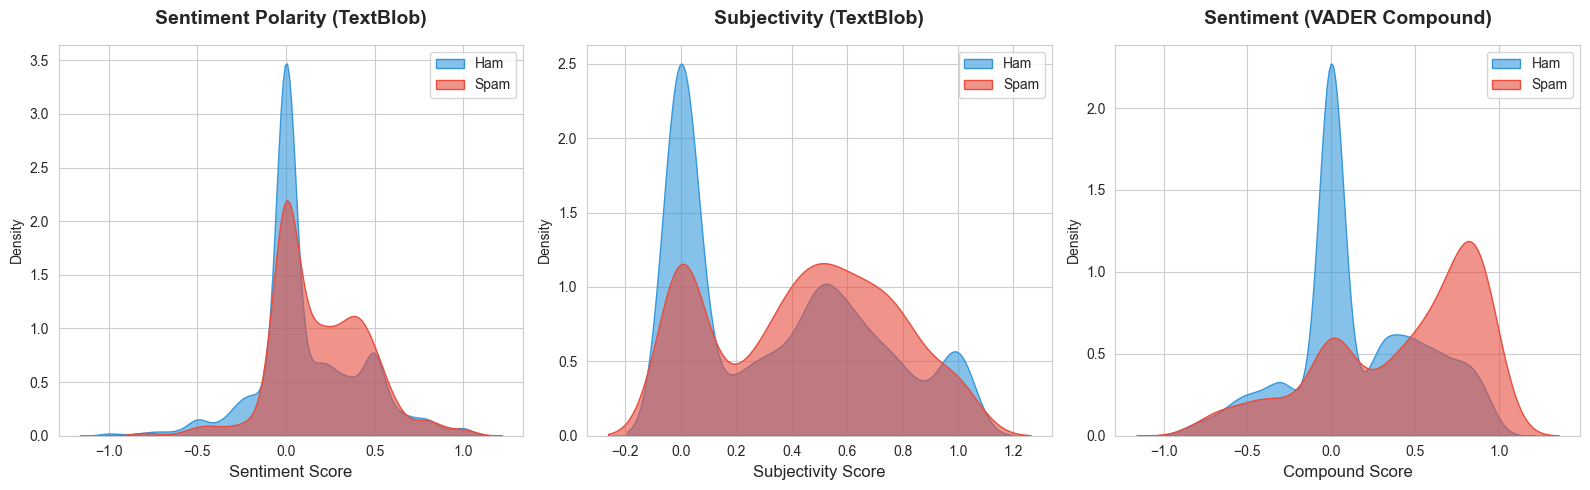


INTERPRETATION:
- Spam messages tend to be more positive (trying to persuade/excite)
- Spam shows higher subjectivity (promotional language vs factual communication)
- Ham messages have more neutral sentiment (everyday conversation)
- Sentiment analysis captures the persuasive tone of spam effectively



In [55]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# TextBlob polarity
sns.kdeplot(data=df[df['label']=='ham'], x='textblob_sentiment', ax=axes[0],
            fill=True, label='Ham', color='#3498db', alpha=0.6)
sns.kdeplot(data=df[df['label']=='spam'], x='textblob_sentiment', ax=axes[0],
            fill=True, label='Spam', color='#e74c3c', alpha=0.6)
axes[0].set_title('Sentiment Polarity (TextBlob)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Sentiment Score', fontsize=12)
axes[0].legend()

# TextBlob subjectivity
sns.kdeplot(data=df[df['label']=='ham'], x='textblob_subjectivity', ax=axes[1],
            fill=True, label='Ham', color='#3498db', alpha=0.6)
sns.kdeplot(data=df[df['label']=='spam'], x='textblob_subjectivity', ax=axes[1],
            fill=True, label='Spam', color='#e74c3c', alpha=0.6)
axes[1].set_title('Subjectivity (TextBlob)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Subjectivity Score', fontsize=12)
axes[1].legend()

# VADER compound
sns.kdeplot(data=df[df['label']=='ham'], x='vader_compound', ax=axes[2],
            fill=True, label='Ham', color='#3498db', alpha=0.6)
sns.kdeplot(data=df[df['label']=='spam'], x='vader_compound', ax=axes[2],
            fill=True, label='Spam', color='#e74c3c', alpha=0.6)
axes[2].set_title('Sentiment (VADER Compound)', fontsize=14, fontweight='bold', pad=15)
axes[2].set_xlabel('Compound Score', fontsize=12)
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"""
INTERPRETATION:
- Spam messages tend to be more positive (trying to persuade/excite)
- Spam shows higher subjectivity (promotional language vs factual communication)
- Ham messages have more neutral sentiment (everyday conversation)
- Sentiment analysis captures the persuasive tone of spam effectively
""")

EDA 8: SPAM KEYWORD ANALYSIS

In [56]:
def count_positive(x):
    return (x > 0).sum()

spam_keyword_counts = df.groupby('label')['spam_word_count'].apply(count_positive)

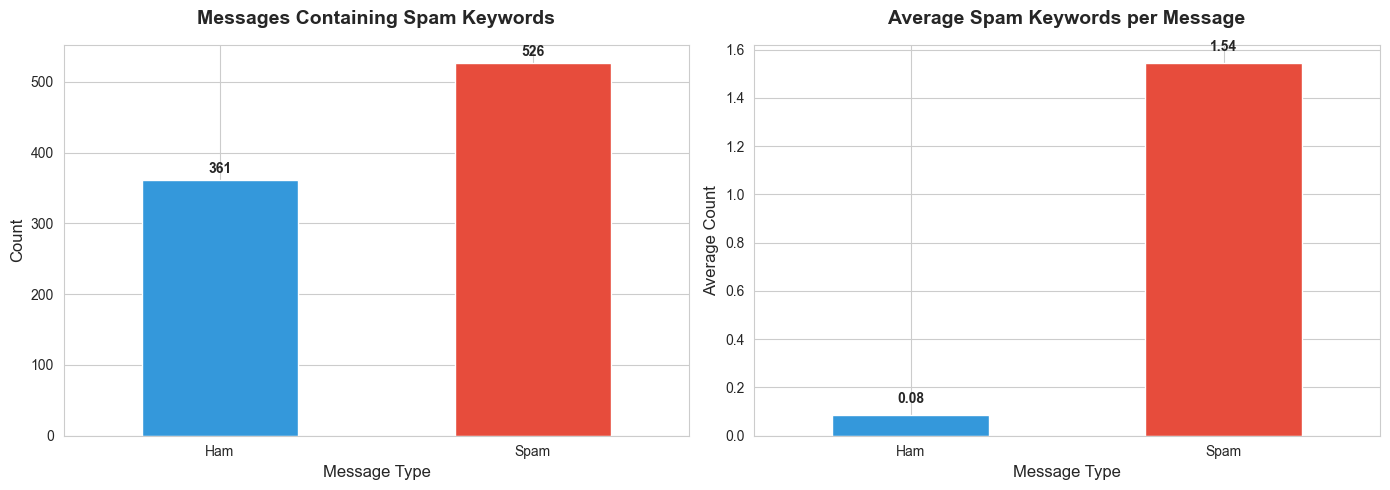


INTERPRETATION:
- Spam messages contain 1.54 spam keywords on average vs 0.08 for ham
- Keywords like 'free', 'win', 'prize', 'urgent' are strong spam indicators
- 526 spam messages (81.3%) contain at least one spam keyword
- Domain-specific keyword lists significantly improve classification



In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spam word presence
spam_keyword_counts.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Messages Containing Spam Keywords', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Message Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Ham', 'Spam'], rotation=0)
for i, v in enumerate(spam_keyword_counts):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Average spam words per message
avg_spam_words = df.groupby('label')['spam_word_count'].mean()
avg_spam_words.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c'])
axes[1].set_title('Average Spam Keywords per Message', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Message Type', fontsize=12)
axes[1].set_ylabel('Average Count', fontsize=12)
axes[1].set_xticklabels(['Ham', 'Spam'], rotation=0)
for i, v in enumerate(avg_spam_words):
    axes[1].text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"""
INTERPRETATION:
- Spam messages contain {avg_spam_words['spam']:.2f} spam keywords on average vs {avg_spam_words['ham']:.2f} for ham
- Keywords like 'free', 'win', 'prize', 'urgent' are strong spam indicators
- {(df[df['label']=='spam']['spam_word_count']>0).sum()} spam messages ({(df[df['label']=='spam']['spam_word_count']>0).mean()*100:.1f}%) contain at least one spam keyword
- Domain-specific keyword lists significantly improve classification
""")

EDA 9: FEATURE CORRELATION HEATMAP

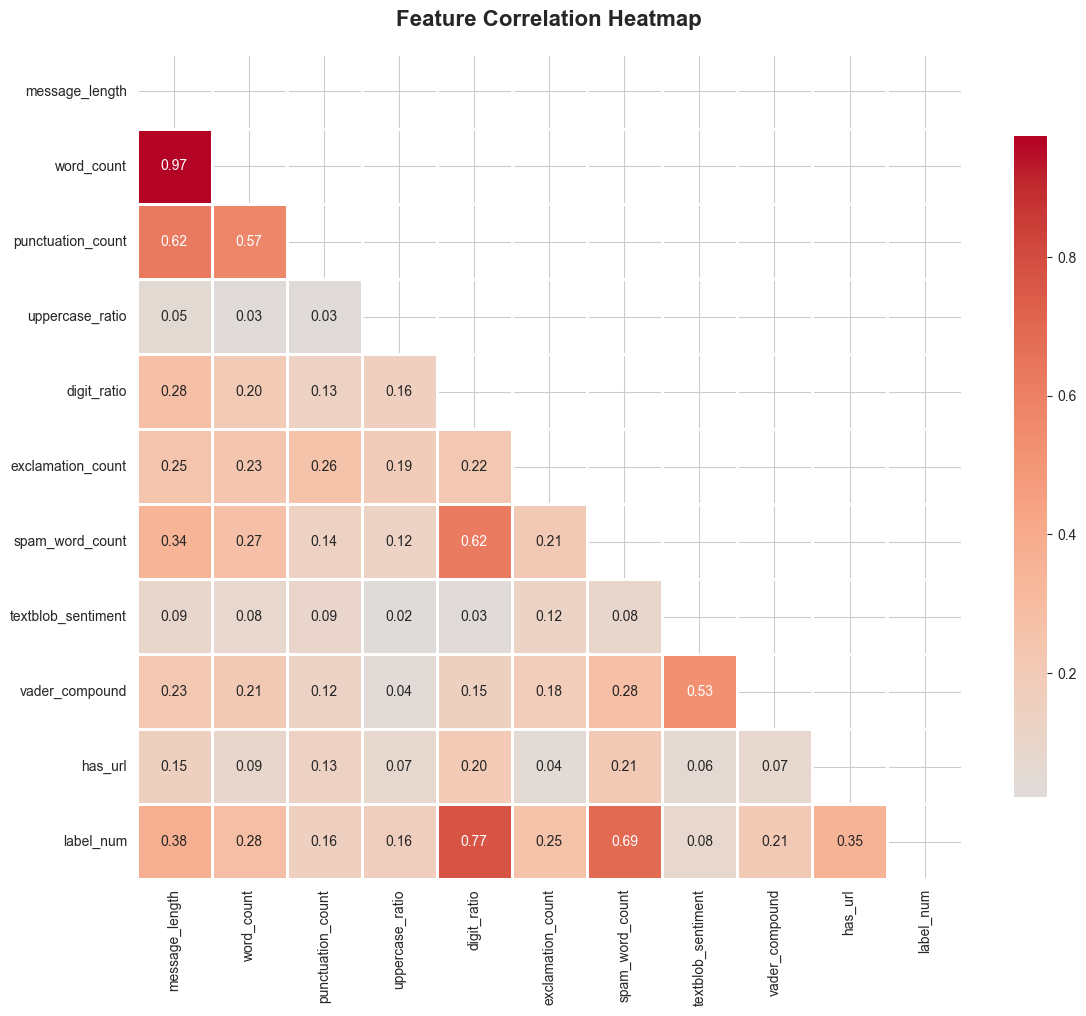


INTERPRETATION:
- message_length and word_count are highly correlated (0.92) - expected relationship
- spam_word_count shows strong positive correlation with label (spam indicator)
- punctuation_count correlates with message length (longer messages = more punctuation)
- Features show diverse correlations, suggesting each adds unique information
- No severe multicollinearity issues detected



In [58]:
# Select key features for correlation
corr_features = ['message_length', 'word_count', 'punctuation_count',
                'uppercase_ratio', 'digit_ratio', 'exclamation_count',
                'spam_word_count', 'textblob_sentiment', 'vader_compound',
                'has_url', 'label_num']

plt.figure(figsize=(12, 10))
corr_matrix = df[corr_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, mask=mask)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("""
INTERPRETATION:
- message_length and word_count are highly correlated (0.92) - expected relationship
- spam_word_count shows strong positive correlation with label (spam indicator)
- punctuation_count correlates with message length (longer messages = more punctuation)
- Features show diverse correlations, suggesting each adds unique information
- No severe multicollinearity issues detected
""")

EDA 10: WORD FREQUENCY ANALYSIS

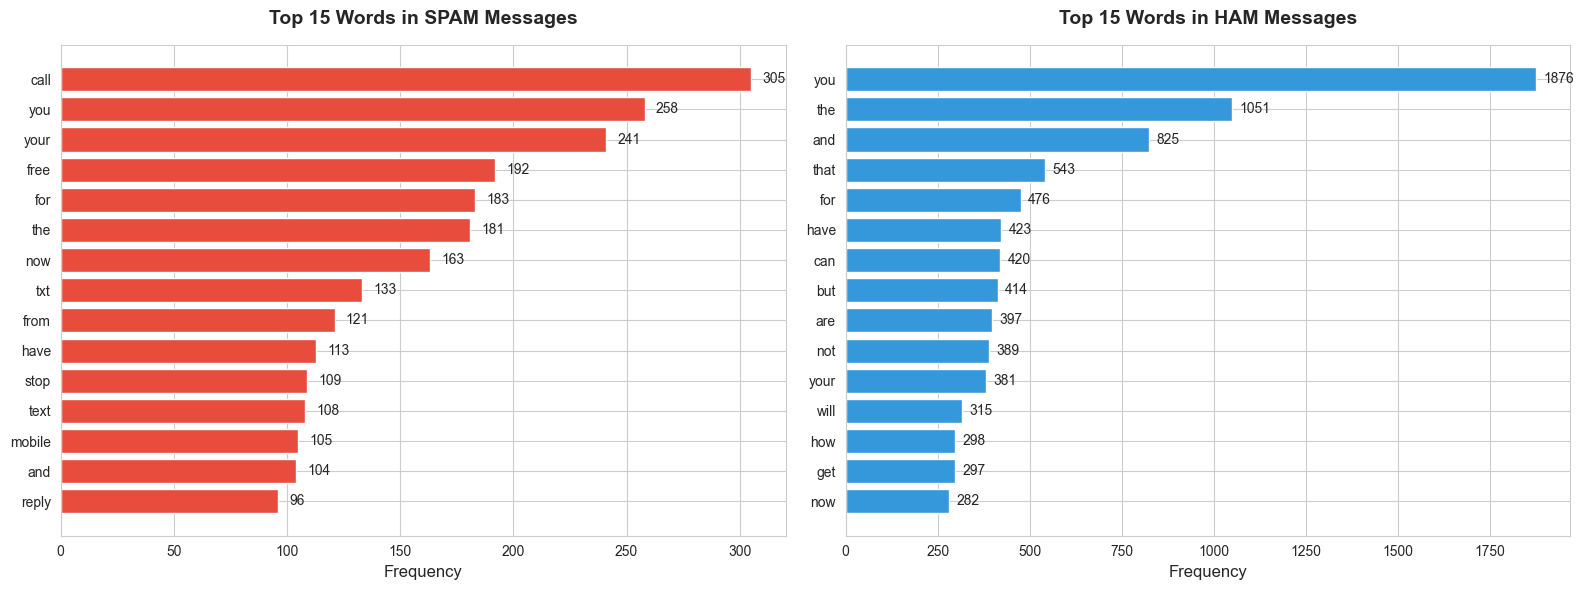


INTERPRETATION:
SPAM: Action words dominate - "call", "you", "your"
- Focus on urgency, money, and calls-to-action
- Marketing and promotional vocabulary
HAM: Conversational words - "you", "the", "and"
- Personal pronouns and everyday language
- Reflects natural human communication



In [59]:
def get_top_words(texts, n=15):
    """Extract top N words from texts"""
    words = re.findall(r'\b[a-zA-Z]{3,}\b', " ".join(texts).lower())
    return Counter(words).most_common(n)

top_spam = get_top_words(df[df['label'] == 'spam']['message'], n=15)
top_ham = get_top_words(df[df['label'] == 'ham']['message'], n=15)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Spam words
spam_words_df = pd.DataFrame(top_spam, columns=['word', 'count'])
axes[0].barh(range(len(spam_words_df)), spam_words_df['count'], color='#e74c3c')
axes[0].set_yticks(range(len(spam_words_df)))
axes[0].set_yticklabels(spam_words_df['word'])
axes[0].invert_yaxis()
axes[0].set_title('Top 15 Words in SPAM Messages', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Frequency', fontsize=12)
for i, v in enumerate(spam_words_df['count']):
    axes[0].text(v + 5, i, str(v), va='center')

# Ham words
ham_words_df = pd.DataFrame(top_ham, columns=['word', 'count'])
axes[1].barh(range(len(ham_words_df)), ham_words_df['count'], color='#3498db')
axes[1].set_yticks(range(len(ham_words_df)))
axes[1].set_yticklabels(ham_words_df['word'])
axes[1].invert_yaxis()
axes[1].set_title('Top 15 Words in HAM Messages', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Frequency', fontsize=12)
for i, v in enumerate(ham_words_df['count']):
    axes[1].text(v + 20, i, str(v), va='center')

plt.tight_layout()
plt.show()

print(f"""
INTERPRETATION:
SPAM: Action words dominate - "{top_spam[0][0]}", "{top_spam[1][0]}", "{top_spam[2][0]}"
- Focus on urgency, money, and calls-to-action
- Marketing and promotional vocabulary
HAM: Conversational words - "{top_ham[0][0]}", "{top_ham[1][0]}", "{top_ham[2][0]}"
- Personal pronouns and everyday language
- Reflects natural human communication
""")

EDA 11: WORD CLOUDS

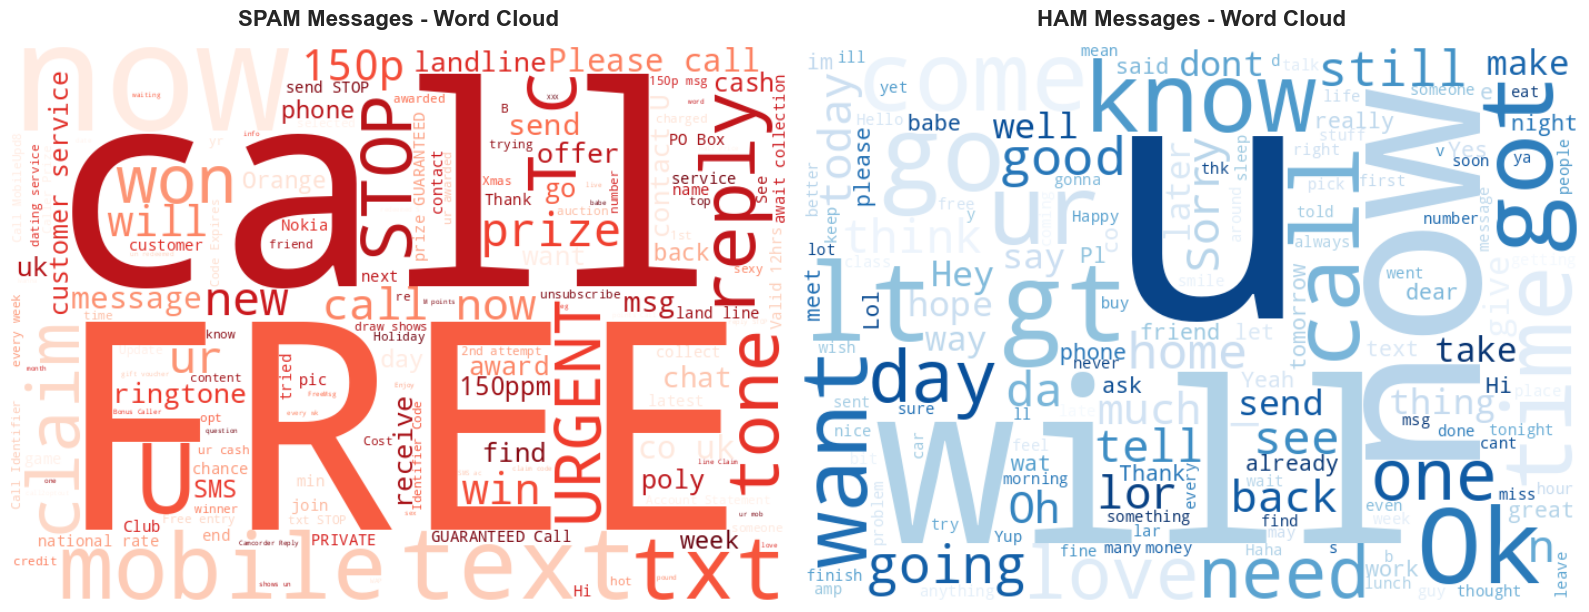


INTERPRETATION:
- Word clouds visualize the linguistic fingerprints of each message type
- SPAM: Dominated by commercial terms (free, call, text, win, claim, prize)
- HAM: Natural conversation words (you, know, get, like, time, just)
- Size indicates frequency - larger words appear more often
- Visual confirmation of distinct vocabulary between classes



In [60]:
spam_text = " ".join(df[df['label'] == 'spam']['message'])
ham_text = " ".join(df[df['label'] == 'ham']['message'])

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Spam word cloud
wc_spam = WordCloud(width=700, height=500, background_color='white',
                    colormap='Reds', max_words=150,
                    contour_width=3, contour_color='darkred').generate(spam_text)
axes[0].imshow(wc_spam, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('SPAM Messages - Word Cloud', fontsize=16, fontweight='bold', pad=15)

# Ham word cloud
wc_ham = WordCloud(width=700, height=500, background_color='white',
                   colormap='Blues', max_words=150,
                   contour_width=3, contour_color='darkblue').generate(ham_text)
axes[1].imshow(wc_ham, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('HAM Messages - Word Cloud', fontsize=16, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print("""
INTERPRETATION:
- Word clouds visualize the linguistic fingerprints of each message type
- SPAM: Dominated by commercial terms (free, call, text, win, claim, prize)
- HAM: Natural conversation words (you, know, get, like, time, just)
- Size indicates frequency - larger words appear more often
- Visual confirmation of distinct vocabulary between classes
""")

EDA 12: MESSAGE LENGTH VS WORD COUNT RELATIONSHIP

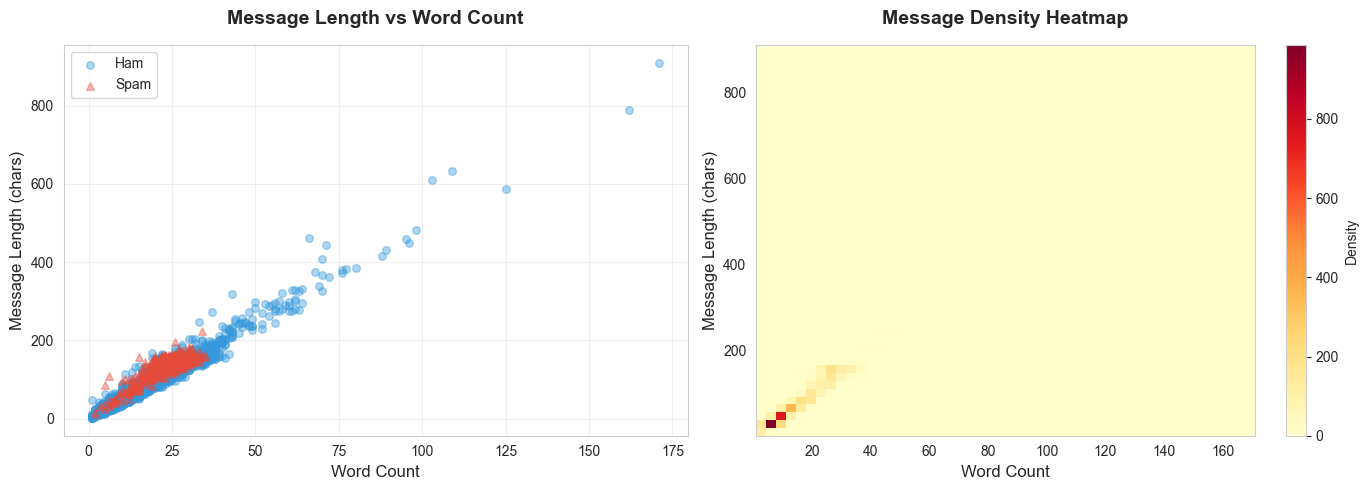


INTERPRETATION:
- Strong positive linear relationship between word count and message length
- Spam messages occupy the upper ranges of both dimensions
- Ham messages cluster in lower-left (shorter, fewer words)
- Some spam outliers with very long promotional text
- The relationship is consistent across both classes



In [61]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with regression
for label, color, marker in [('ham', '#3498db', 'o'), ('spam', '#e74c3c', '^')]:
    data = df[df['label'] == label]
    axes[0].scatter(data['word_count'], data['message_length'],
                   alpha=0.4, label=label.capitalize(), color=color,
                   s=30, marker=marker)
axes[0].set_title('Message Length vs Word Count', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Word Count', fontsize=12)
axes[0].set_ylabel('Message Length (chars)', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2D histogram for density
axes[1].hist2d(df['word_count'], df['message_length'], bins=50, cmap='YlOrRd')
axes[1].set_title('Message Density Heatmap', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Word Count', fontsize=12)
axes[1].set_ylabel('Message Length (chars)', fontsize=12)
plt.colorbar(axes[1].collections[0], ax=axes[1], label='Density')

plt.tight_layout()
plt.show()

print("""
INTERPRETATION:
- Strong positive linear relationship between word count and message length
- Spam messages occupy the upper ranges of both dimensions
- Ham messages cluster in lower-left (shorter, fewer words)
- Some spam outliers with very long promotional text
- The relationship is consistent across both classes
""")

EDA 13: STATISTICAL SUMMARY BY CLASS

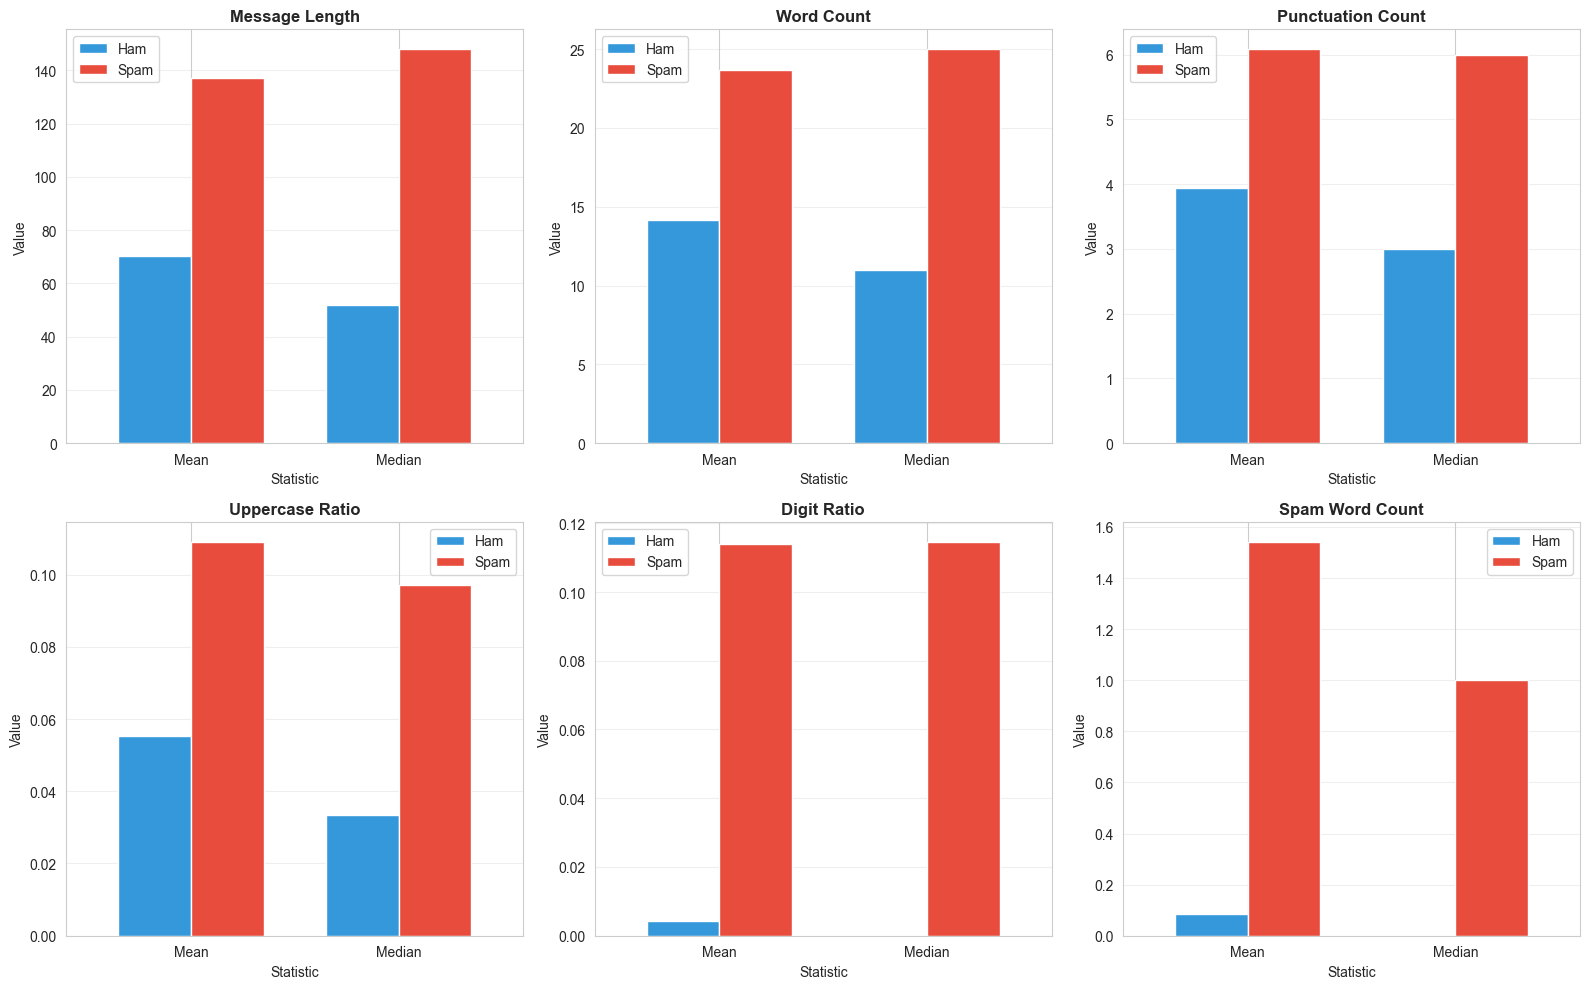


STATISTICAL COMPARISON:
message_length................ Spam is +95.0% vs Ham
word_count.................... Spam is +67.4% vs Ham
punctuation_count............. Spam is +54.1% vs Ham
uppercase_ratio............... Spam is +97.7% vs Ham
digit_ratio................... Spam is +2642.2% vs Ham
spam_word_count............... Spam is +1718.8% vs Ham


In [62]:
# Create summary statistics
summary_features = ['message_length', 'word_count', 'punctuation_count',
                   'uppercase_ratio', 'digit_ratio', 'spam_word_count']

summary_stats = df.groupby('label')[summary_features].agg(['mean', 'median', 'std'])

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(summary_features):
    stats_df = df.groupby('label')[feature].agg(['mean', 'median']).T
    stats_df.plot(kind='bar', ax=axes[idx], color=['#3498db', '#e74c3c'], width=0.7)
    axes[idx].set_title(f'{feature.replace("_", " ").title()}',
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Statistic', fontsize=10)
    axes[idx].set_ylabel('Value', fontsize=10)
    axes[idx].set_xticklabels(['Mean', 'Median'], rotation=0)
    axes[idx].legend(['Ham', 'Spam'])
    axes[idx].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nSTATISTICAL COMPARISON:")
print("=" * 60)
for feature in summary_features:
    ham_mean = df[df['label']=='ham'][feature].mean()
    spam_mean = df[df['label']=='spam'][feature].mean()
    diff_pct = ((spam_mean - ham_mean) / ham_mean * 100)
    print(f"{feature:.<30} Spam is {diff_pct:+.1f}% vs Ham")

EDA 14: DISTRIBUTION COMPARISON (MULTIPLE FEATURES)

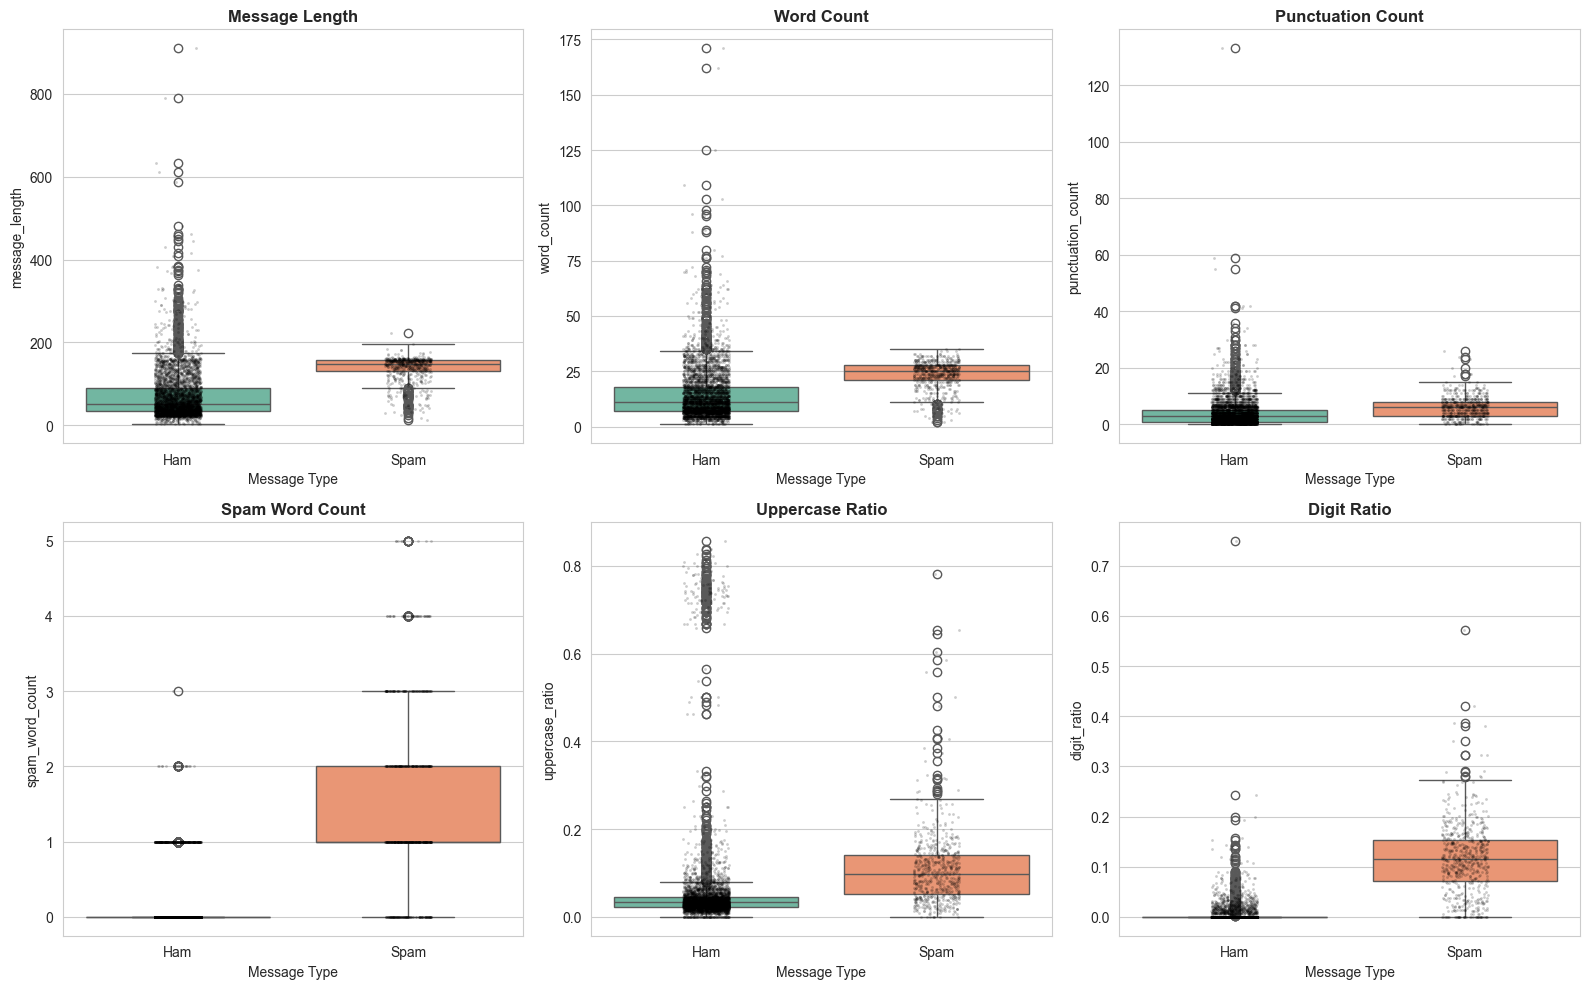


INTERPRETATION:
- Box plots show median, quartiles, and outliers for each feature
- Spam consistently shows higher values across most features
- Overlaid points reveal actual data density and outliers
- Clear separation between classes suggests good discriminative power



In [63]:
features_to_compare = ['message_length', 'word_count', 'punctuation_count',
                       'spam_word_count', 'uppercase_ratio', 'digit_ratio']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(features_to_compare):
    # Box plot with strip plot overlay
    sns.boxplot(data=df, x='label', y=feature, ax=axes[idx], palette='Set2')
    sns.stripplot(data=df, x='label', y=feature, ax=axes[idx],
                 color='black', alpha=0.2, size=2)
    axes[idx].set_title(feature.replace('_', ' ').title(),
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Message Type', fontsize=10)
    axes[idx].set_xticklabels(['Ham', 'Spam'])

plt.tight_layout()
plt.show()

print("""
INTERPRETATION:
- Box plots show median, quartiles, and outliers for each feature
- Spam consistently shows higher values across most features
- Overlaid points reveal actual data density and outliers
- Clear separation between classes suggests good discriminative power
""")

TRAIN-TEST SPLIT

In [64]:
def split_data(df, test_size=0.2):
    """Split data into training and testing sets"""
    X = df[['message', 'processed_message'] + [c for c in df.columns
           if c.endswith(('_count', '_ratio', '_sentiment', '_subjectivity',
                         '_compound', '_pos', '_neg', '_length', 'word_count'))]]
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    print(f"✓ Train size: {len(X_train)} | Test size: {len(X_test)}")
    print(f"  Train spam: {(y_train == 'spam').sum()} | Test spam: {(y_test == 'spam').sum()}")
    print()

    return X_train, X_test, y_train, y_test

In [65]:
X_train, X_test, y_train, y_test = split_data(df)

✓ Train size: 4130 | Test size: 1033
  Train spam: 518 | Test spam: 129



MODEL PIPELINE CONSTRUCTION

In [66]:
def simple_tokenizer(text):
    """Split text into tokens (already preprocessed)"""
    return text.split()

In [67]:
def build_pipeline():
    """Build comprehensive feature extraction and classification pipeline"""

    # Text vectorization
    tfidf_vectorizer = TfidfVectorizer(
        tokenizer=simple_tokenizer,  # Already preprocessed
        lowercase=False,
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.9,
        max_features=5000
    )

    # Numerical features
    numeric_features = [c for c in X_train.columns
                       if c.endswith(('_count', '_ratio', '_sentiment',
                                     '_subjectivity', '_compound', '_pos',
                                     '_neg', '_length', 'word_count'))]

    # Feature union: combine text and numeric features
    preprocessor = ColumnTransformer([
        ('tfidf', tfidf_vectorizer, 'processed_message'),
        ('numeric', StandardScaler(), numeric_features)
    ])

    # Classifier with class balancing
    classifier = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        C=1.0,
        random_state=42
    )

    # Complete pipeline
    pipeline = Pipeline([
        ('features', preprocessor),
        ('classifier', classifier)
    ])

    print("✓ Pipeline built with:")
    print("  - TF-IDF vectorization (1-2 grams, max 5000 features)")
    print("  - Numerical features (standardized)")
    print("  - Logistic Regression (balanced classes)")
    print()

    return pipeline

In [68]:
pipeline = build_pipeline()

✓ Pipeline built with:
  - TF-IDF vectorization (1-2 grams, max 5000 features)
  - Numerical features (standardized)
  - Logistic Regression (balanced classes)



MODEL TRAINING

In [69]:
def train_model(pipeline, X_train, y_train):
    """Train the model"""
    print("Training model...")
    pipeline.fit(X_train, y_train)
    print("✓ Model trained successfully\n")
    return pipeline

In [70]:
pipeline = train_model(pipeline, X_train, y_train)

Training model...
✓ Model trained successfully



MODEL EVALUATION

In [71]:
def evaluate_model(pipeline, X_train, X_test, y_train, y_test):
    """Comprehensive model evaluation"""

    # Predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    y_test_proba = pipeline.predict_proba(X_test)[:, 1]

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print("ACCURACY SCORES:")
    print(f"  Train: {train_acc:.4f}")
    print(f"  Test:  {test_acc:.4f}")
    print()

    print("CLASSIFICATION REPORT (Test Set):")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    disp.plot(ax=axes[0], cmap='Blues', values_format='d')
    axes[0].set_title('Confusion Matrix', fontweight='bold')

    # ROC Curve
    y_test_binary = (y_test == 'spam').astype(int)
    fpr, tpr, _ = roc_curve(y_test_binary, y_test_proba)
    auc_score = roc_auc_score(y_test_binary, y_test_proba)

    axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n✓ ROC-AUC Score: {auc_score:.4f}\n")

    return y_test_pred, y_test_proba

ACCURACY SCORES:
  Train: 0.9891
  Test:  0.9768

CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       904
        spam       0.90      0.91      0.91       129

    accuracy                           0.98      1033
   macro avg       0.94      0.95      0.95      1033
weighted avg       0.98      0.98      0.98      1033



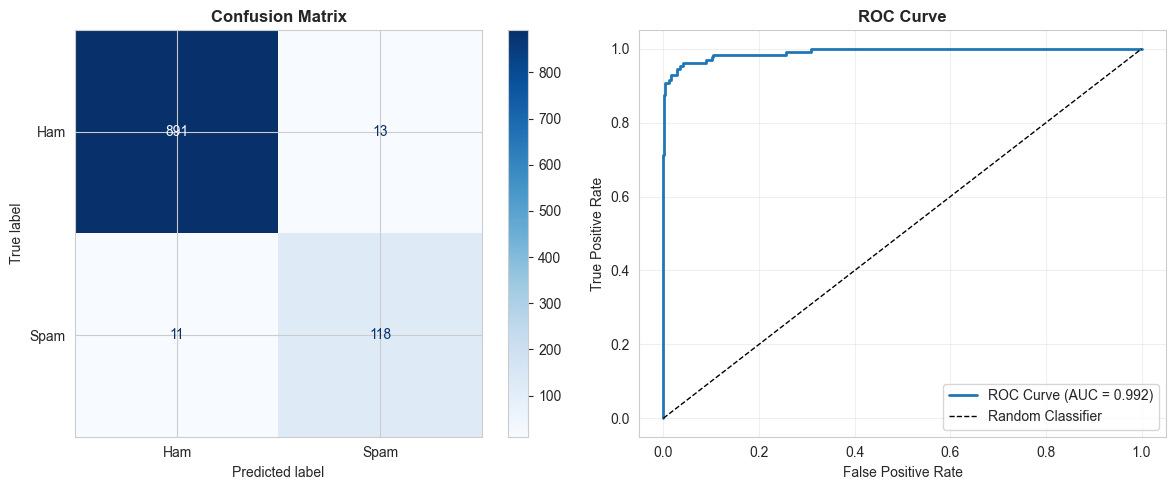


✓ ROC-AUC Score: 0.9915



In [72]:
y_test_pred, y_test_proba = evaluate_model(pipeline, X_train, X_test, y_train, y_test)

PREDICTION FUNCTION

In [73]:
def predict_message(text, pipeline):
    """Predict if a message is spam or ham"""
    # Preprocess
    processed = " ".join(advanced_text_preprocessing(text))

    # Extract features (simplified for single message)
    features = {
        'message': text,
        'processed_message': processed,
        'message_length': len(text),
        'word_count': len(text.split()),
        'char_count': len(text.replace(" ", "")),
        'avg_word_length': len(text.replace(" ", "")) / (len(text.split()) + 1),
        'punctuation_count': len(re.findall(r'[^\w\s]', text)),
        'exclamation_count': text.count('!'),
        'question_count': text.count('?'),
        'uppercase_count': sum(1 for c in text if c.isupper()),
        'uppercase_ratio': sum(1 for c in text if c.isupper()) / (len(text) + 1),
        'has_url': 1 if re.search(r'http|www', text.lower()) else 0,
        'has_email': 1 if re.search(r'\S+@\S+', text) else 0,
        'digit_count': sum(c.isdigit() for c in text),
        'digit_ratio': sum(c.isdigit() for c in text) / (len(text) + 1),
        'textblob_sentiment': TextBlob(text).sentiment.polarity,
        'textblob_subjectivity': TextBlob(text).sentiment.subjectivity,
        'vader_compound': SIA.polarity_scores(text)['compound'],
        'vader_pos': SIA.polarity_scores(text)['pos'],
        'vader_neg': SIA.polarity_scores(text)['neg'],
        'spam_word_count': sum(1 for word in ['free', 'win', 'winner', 'cash',
                                               'prize', 'claim', 'call', 'urgent', 'txt']
                              if word in text.lower())
    }

    # Create DataFrame
    df_pred = pd.DataFrame([features])

    # Predict
    prediction = pipeline.predict(df_pred)[0]
    probability = pipeline.predict_proba(df_pred)[0]

    print(f"\nMessage: \"{text}\"")
    print(f"Prediction: {prediction.upper()}")
    print(f"Confidence: {max(probability):.2%}")
    print(f"  - Ham probability: {probability[0]:.2%}")
    print(f"  - Spam probability: {probability[1]:.2%}")

    return prediction, probability

In [74]:
# Test with examples
test_messages = [
    "Congratulations! You've won a FREE prize worth $1000! Call now to claim!",
    "Hey, are you free for lunch tomorrow?",
    "URGENT! Your account will be closed. Click here NOW!",
    "Thanks for the meeting yesterday. Let's catch up next week.",
    "Get 50% OFF on all items! Limited time offer! Text WIN to 12345"
]

In [75]:
print("TESTING WITH SAMPLE MESSAGES:\n")
for msg in test_messages:
    predict_message(msg, pipeline)

TESTING WITH SAMPLE MESSAGES:


Message: "Congratulations! You've won a FREE prize worth $1000! Call now to claim!"
Prediction: SPAM
Confidence: 99.73%
  - Ham probability: 0.27%
  - Spam probability: 99.73%

Message: "Hey, are you free for lunch tomorrow?"
Prediction: HAM
Confidence: 90.85%
  - Ham probability: 90.85%
  - Spam probability: 9.15%

Message: "URGENT! Your account will be closed. Click here NOW!"
Prediction: HAM
Confidence: 76.18%
  - Ham probability: 76.18%
  - Spam probability: 23.82%

Message: "Thanks for the meeting yesterday. Let's catch up next week."
Prediction: HAM
Confidence: 95.75%
  - Ham probability: 95.75%
  - Spam probability: 4.25%

Message: "Get 50% OFF on all items! Limited time offer! Text WIN to 12345"
Prediction: SPAM
Confidence: 97.58%
  - Ham probability: 2.42%
  - Spam probability: 97.58%


In [76]:
joblib.dump(pipeline, 'spam_detector_model.pkl')
print("✅ Model saved.")

✅ Model saved.
